In [1]:
import os, sys, time
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import mvpa2.suite as mvpa2
import itertools

from collections import Counter

import matplotlib.pylab as plt
%matplotlib inline

from scipy.spatial.distance import pdist,squareform

TR = 2.3

brands = np.array(['abercrombie-fitch','adobe','apple','axe','beats',
          'campina','dell','disney','durex','heineken','kelloggs',
          'microsoft','pampers','redbull'])

cat_names = ['party','work','sex','family']

sns.reset_orig()
plt.rc('font', family='Arial', size=16)
plt.rc('legend', fontsize='medium')
plt.rc('savefig', dpi=300)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/pylab/config.py:95: DeprecationWarning: metadata {'config': True} was set from the const

In [23]:
method = 'normalized_common'
r = 'picture_2_clust_10'

file_path = '../output/'+method+'/'+r.replace("picture","brand")

subj_brand_ds = {}
allsubjs = np.array(range(4,42))

for subj in allsubjs:
    subj_brand_ds[subj] = mvpa2.Dataset.from_hdf5(file_path+'/S'+str(subj)+'.h5py')

In [3]:
def zscore(data):
    return (data-np.nanmean(data))/np.nanstd(data)

In [4]:
def mean_corr(data):
    return np.tanh(np.mean(np.arctanh(data)))

In [24]:
tp = 6

subj_behave = []
subj_neural = []
subj_cobrand = []
subj_brightness = []

rdm_dist = []
bright_dist = []

output = np.zeros((38*91,5)) * np.nan

#subjs = allsubjs[allsubjs != 8]
for subj in allsubjs[allsubjs != 8]:
    brand_ds = subj_brand_ds[subj]

    rdm_file =  '../mds/S'+str(subj)+'_mds.mat'
    behave_rdm = np.ravel(sp.io.loadmat(rdm_file)['estimate_dissimMat_ltv'])

    cobrand_rdm = np.zeros(91) * np.nan
    if os.path.isfile('../survey/cobrand/S'+str(subj)+'_cobrand.npy'):
        cobrand_rdm = np.load('../survey/cobrand/S'+str(subj)+'_cobrand.npy')
        cobrand_rdm = np.mean(cobrand_rdm,axis=1)
        cobrand_rdm[cobrand_rdm < 0] = np.nan

    brightness = []
    neural_rdm = []
    for b in range(14):
        neural_rdm.append(np.mean(np.array(brand_ds[(brand_ds.sa.brand == brands[b]) & \
                                 (brand_ds.sa.timepoint >= tp) & \
                                 (brand_ds.sa.timepoint < tp+TR)]\
                                .sa['t02_rsa']),axis=0))
        #neural_rdm.append(np.mean([\
        #    np.mean(brand_ds[(brand_ds.sa.brand == brands[b]) & \
        #            (brand_ds.sa.timepoint >= tp+(TR*i)) & \
        #            (brand_ds.sa.timepoint < tp+(TR*(i+1)))].sa['t0_rsa'],axis=0)\
        #               for i in [0,2]],axis=0))
        brightness.append(np.mean(brand_ds[(brand_ds.sa.brand == brands[b])].sa.brightness))

    neural_rdm = pdist(np.array(neural_rdm),metric='correlation')

    brightness_rdm = np.zeros((14,14))
    for i in range(14):
        for j in range(14):
            brightness_rdm[i,j] = np.abs(brightness[i] - brightness[j])
    brightness_rdm = squareform(brightness_rdm)

    rdm_dist.append(sp.stats.spearmanr(neural_rdm,behave_rdm)[0])
    bright_dist.append(sp.stats.pearsonr(neural_rdm,brightness_rdm)[0])

    idx = np.where(allsubjs == subj)[0][0]*91
    output[idx:idx+91,0] = subj
    output[idx:idx+91,1] = behave_rdm
    output[idx:idx+91,2] = cobrand_rdm
    output[idx:idx+91,3] = neural_rdm
    output[idx:idx+91,4] = brightness_rdm

    subj_behave.append(zscore(behave_rdm))
    subj_neural.append(zscore(neural_rdm))
    subj_cobrand.append(cobrand_rdm)
    subj_brightness.append(brightness_rdm)

subj_behave = np.array(subj_behave)
subj_neural = np.array(subj_neural)
subj_cobrand = np.array(subj_cobrand)
subj_brightness = np.array(subj_brightness)

f = open('brand_'+method+'_'+r+'_rdm.csv','w')
f.write('subj,behave,cobrand,neural,brightness\n')
for o in output:
    text_o = [str(oo) for oo in o]
    f.write(','.join(text_o)+'\n') 
f.close()

x = np.nanmean(subj_neural,axis=0)
y = np.nanmean(subj_cobrand,axis=0)
z = np.nanmean(subj_behave,axis=0)
w = np.nanmean(subj_brightness,axis=0)

output = np.zeros((91,5)) * np.nan
output[:,0] = x
output[:,1] = y
output[:,2] = z
output[:,3] = w

print mean_corr(rdm_dist)
print mean_corr(bright_dist)

0.100882400731
-0.0942829112316
-0.0814328668666


## Supplementary Analysis 11

In [14]:
output = np.zeros((38*4*14,5)) * np.nan

all_res = []
all_res2 = []

for tp in range(19):
    
    subj_behave = []
    subj_neural = []
    subj_cobrand = []
    subj_brightness = []

    rdm_dist = []
    bright_dist = []

    output = np.zeros((38*91,6)) * np.nan

    subjs = allsubjs[allsubjs != 8]
    for subj in allsubjs:
        brand_ds = subj_brand_ds[subj]

        rdm_file =  '../mds/S'+str(subj)+'_mds.mat'
        behave_rdm = np.ravel(sp.io.loadmat(rdm_file)['estimate_dissimMat_ltv'])

        cobrand_rdm = np.zeros(91) * np.nan
        if os.path.isfile('../survey/cobrand/S'+str(subj)+'_cobrand.npy'):
            cobrand_rdm = np.load('../survey/cobrand/S'+str(subj)+'_cobrand.npy')
            cobrand_rdm = np.mean(cobrand_rdm,axis=1)
            cobrand_rdm[cobrand_rdm < 0] = np.nan

        brightness = []
        neural_rdm = []
        for b in range(14):
            neural_rdm.append(np.mean(np.array(brand_ds[(brand_ds.sa.brand == brands[b]) & \
                                     (brand_ds.sa.timepoint >= tp) & \
                                     (brand_ds.sa.timepoint < tp+TR)]\
                                    .sa['t0_rsa']),axis=0))
            #neural_rdm.append(np.mean([\
            #    np.mean(brand_ds[(brand_ds.sa.brand == brands[b]) & \
            #            (brand_ds.sa.timepoint >= tp+(TR*i)) & \
            #            (brand_ds.sa.timepoint < tp+(TR*(i+1)))].sa['t0_rsa'],axis=0)\
            #               for i in [0,2]],axis=0))
            brightness.append(np.mean(brand_ds[(brand_ds.sa.brand == brands[b])].sa.brightness))

        neural_rdm = pdist(np.array(neural_rdm),metric='correlation')

        brightness_rdm = np.zeros((14,14))
        for i in range(14):
            for j in range(14):
                brightness_rdm[i,j] = np.abs(brightness[i] - brightness[j])
        brightness_rdm = squareform(brightness_rdm)

        rdm_dist.append(sp.stats.spearmanr(neural_rdm,behave_rdm)[0])
        bright_dist.append(sp.stats.pearsonr(neural_rdm,brightness_rdm)[0])

        idx = np.where(allsubjs == subj)[0][0]*91
        output[idx:idx+91,0] = subj
        output[idx:idx+91,1] = behave_rdm
        output[idx:idx+91,2] = cobrand_rdm
        output[idx:idx+91,3] = neural_rdm
        output[idx:idx+91,4] = brightness_rdm

        subj_behave.append(zscore(behave_rdm))
        subj_neural.append(zscore(neural_rdm))
        subj_cobrand.append(cobrand_rdm)
        subj_brightness.append(brightness_rdm)

    subj_behave = np.array(subj_behave)
    subj_neural = np.array(subj_neural)
    subj_cobrand = np.array(subj_cobrand)
    subj_brightness = np.array(subj_brightness)

    x = np.nanmean(subj_neural,axis=0)
    y = np.nanmean(subj_cobrand,axis=0)
    z = np.nanmean(subj_behave,axis=0)
    w = np.nanmean(subj_brightness,axis=0)

    res = sp.stats.pearsonr(x,z)
    print res[0],res[1]
    all_res.append(res[0])
    
    res = sp.stats.pearsonr(x,y)
    print res[0],res[1]
    all_res2.append(res[0])

0.1954851467 0.0633125863258
-0.128390142337 0.225183401215
0.262813758311 0.011841370291
-0.182617573127 0.0831703301512
0.246298523175 0.0186007776359
-0.185400322262 0.0785019011355
0.364237089914 0.000386237855945
-0.259370588734 0.0130398806804
0.351852544832 0.000625950343399
-0.27260993543 0.00894110730158
0.338691293346 0.00102391708789
-0.244069035052 0.0197290288272
0.42823663546 2.29039517017e-05
-0.373442847011 0.00026634489692
0.359956480676 0.00045739086539
-0.306430997854 0.00313508569624
0.363058257049 0.000404742867447
-0.330660852972 0.00136831240229
0.37487773064 0.00025110252903
-0.346614056093 0.000763335848545
0.359711935233 0.000461797809118
-0.296841313331 0.00427341439393
0.362860308394 0.000407928874708
-0.312205155089 0.00258878840465
0.326864965356 0.00156511679355
-0.258764027887 0.0132615971095
0.179212110842 0.0891813598973
-0.136480112686 0.197055876496
0.136732072812 0.196222441422
-0.0791022466419 0.456075257965
0.231040823227 0.0275648088412
-0.178039

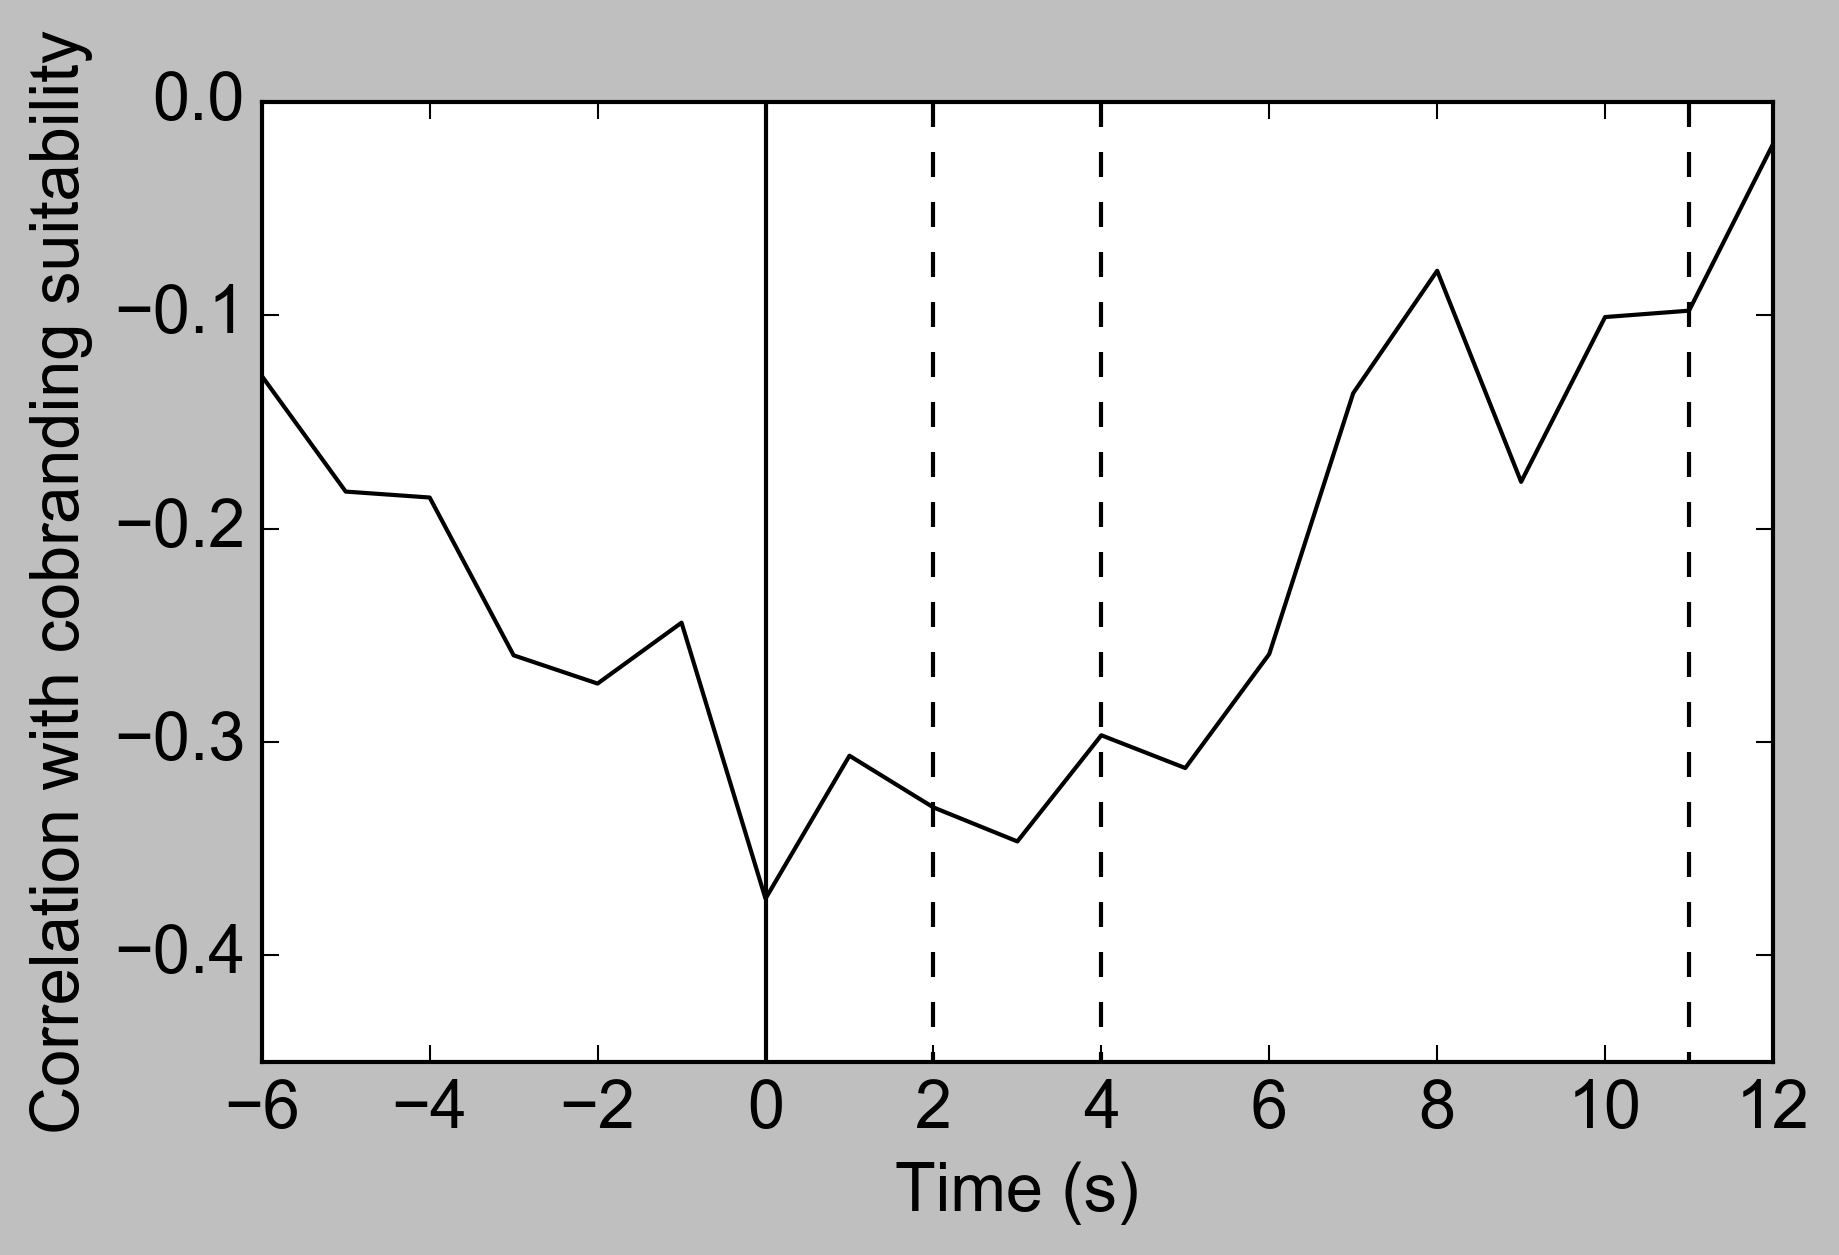

In [35]:
plt.figure(figsize=(6.5,4))
plt.plot(range(-6,13),all_res2,'k')
plt.plot([0,0],[0,-0.45],'k')
plt.plot([2,2],[0,-0.45],'k--')
plt.plot([4,4],[0,-0.45],'k--')
plt.plot([11,11],[0,-0.45],'k--')
plt.yticks([0,-0.1,-0.2,-0.3,-0.4])
plt.xlabel("Time (s)")
plt.ylabel("Correlation with cobranding suitability")
plt.savefig("robust_time_1.pdf",fmt="pdf")
plt.show()

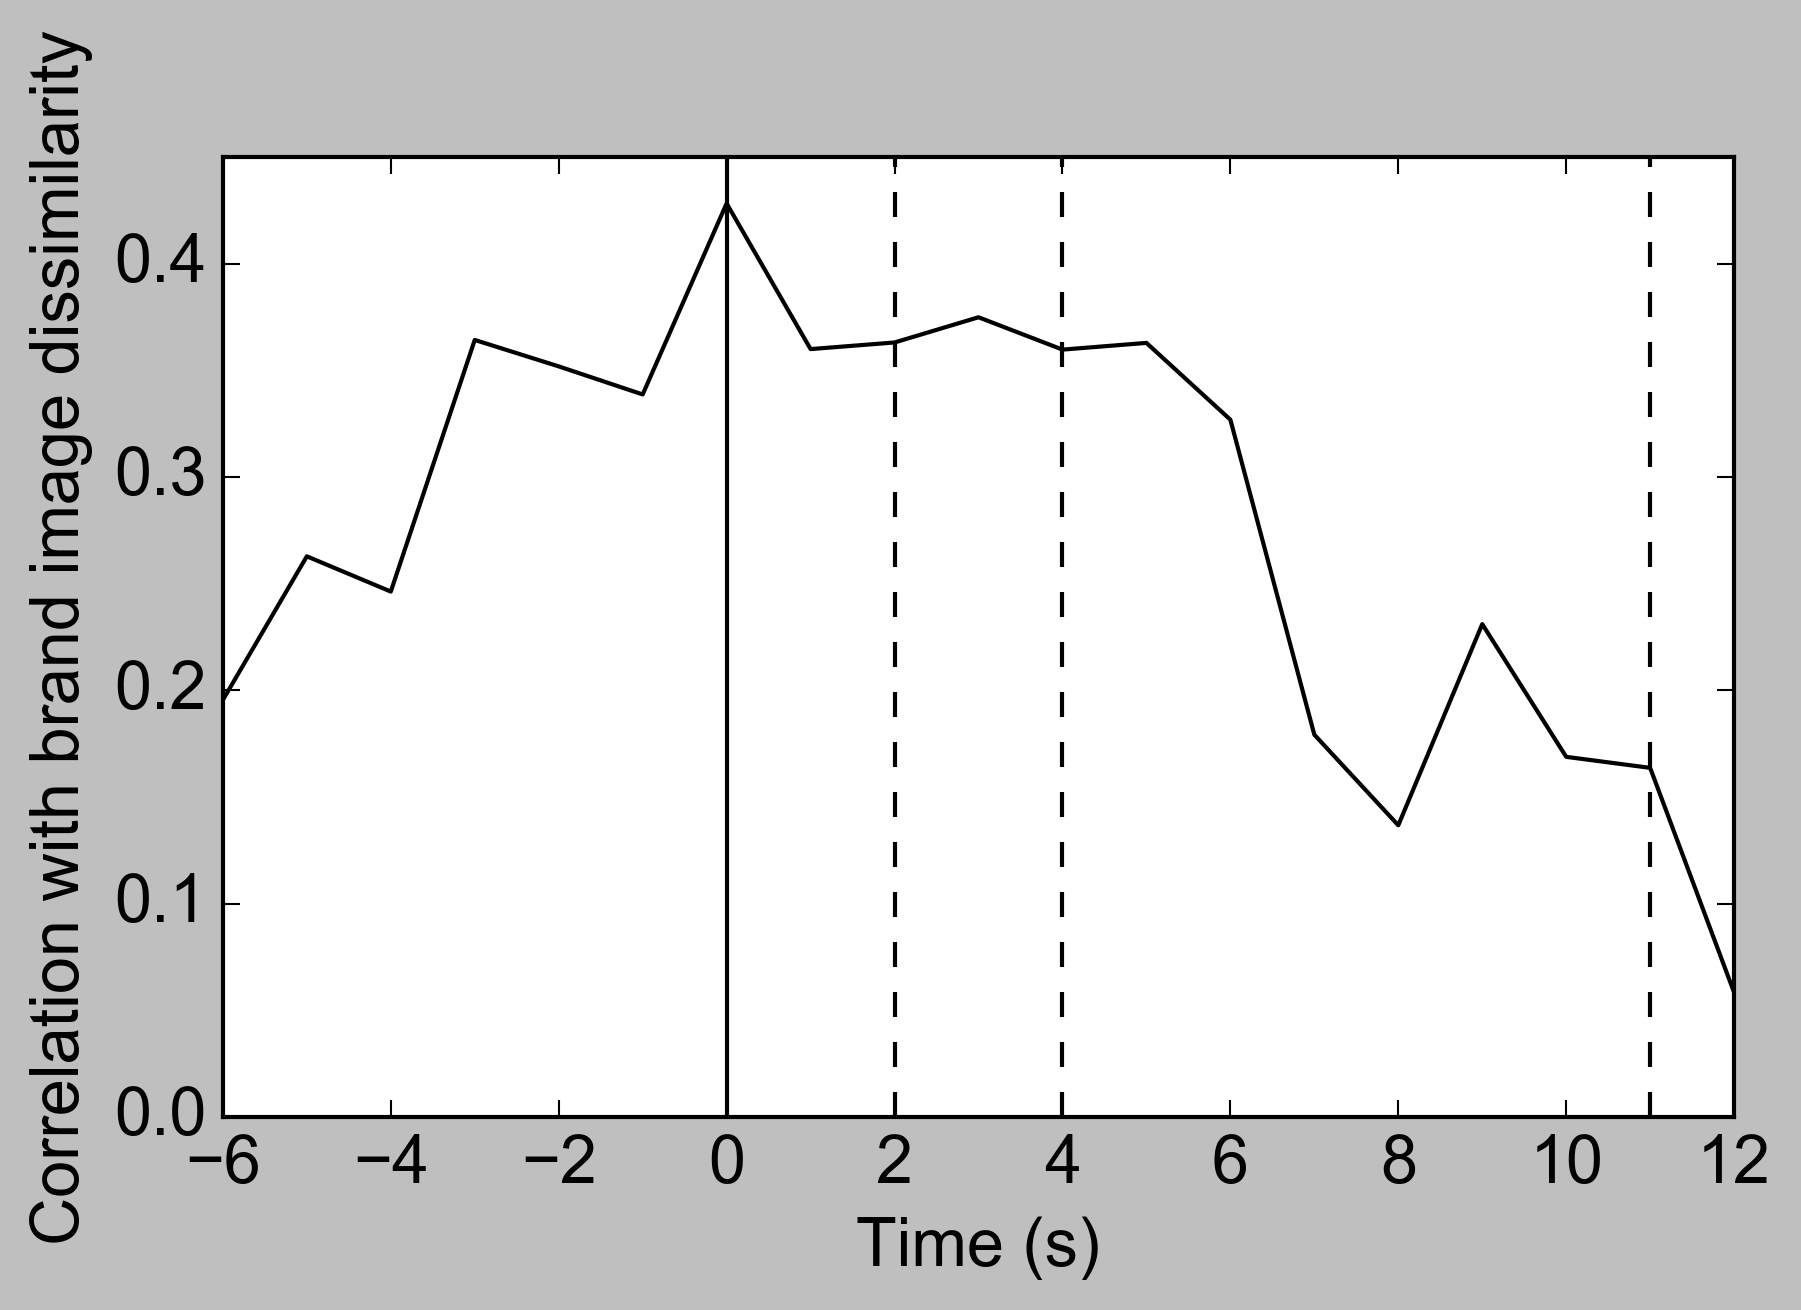

In [36]:
plt.figure(figsize=(6.5,4))

plt.plot(range(-6,13),all_res,'k')
plt.plot([0,0],[0,0.45],'k')
plt.plot([2,2],[0,0.45],'k--')
plt.plot([4,4],[0,0.45],'k--')
plt.plot([11,11],[0,0.45],'k--')
plt.xlabel("Time (s)")
plt.yticks([0,0.1,0.2,0.3,0.4])
plt.ylabel("Correlation with brand image dissimilarity")
plt.savefig("robust_time_2.pdf",fmt="pdf")

plt.show()

## Supplementary Analysis 9

In [25]:
output = np.zeros((38*4*14,6)) * np.nan

all_res = []
all_res2 = []

tp = 6
thres = 11

for perm in range(1000):
    mask = (np.arange(112) < thres)
    np.random.shuffle(mask)
    
    subj_neural = []

    for subj in allsubjs[allsubjs != 8]:
        brand_ds = subj_brand_ds[subj]

        neural_rdm = []
        for b in range(14):
            neural_rdm.append(np.mean(np.array(brand_ds[(brand_ds.sa.brand == brands[b]) & \
                                     (brand_ds.sa.timepoint >= tp) & \
                                     (brand_ds.sa.timepoint < tp+TR)]\
                                    .sa['t012_rsa']),axis=0))

        neural_rdm = pdist(np.array(neural_rdm)[:,mask],metric='correlation')
        subj_neural.append(zscore(neural_rdm))

    subj_neural = np.array(subj_neural)

    x = np.nanmean(subj_neural,axis=0)

    res = sp.stats.pearsonr(x,z)
    all_res.append(res[0])
    
    res = sp.stats.pearsonr(x,y)
    all_res2.append(res[0])
    if perm % 100 == 0:
        print "*",

* * * * * * * * * *


In [16]:
# 75%
print np.mean(all_res),np.std(all_res)
print np.mean(all_res2),np.std(all_res2)

0.452518294215 0.00693927720614
-0.396021702354 0.00675771411262


In [18]:
# 50%
print np.mean(all_res),np.std(all_res)
print np.mean(all_res2),np.std(all_res2)

0.44957850389 0.0126766199207
-0.393537361873 0.0124394777375


In [20]:
# 25%
print np.mean(all_res),np.std(all_res)
print np.mean(all_res2),np.std(all_res2)

0.440733227359 0.0227521192127
-0.385902508038 0.021793449354


In [26]:
# 10%
print np.mean(all_res),np.std(all_res)
print np.mean(all_res2),np.std(all_res2)

0.415484090848 0.0419154549919
-0.364015202909 0.0405191305162
